In [341]:
# !pip install ucimlrepo

In [342]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [343]:
from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression


In [348]:
from ucimlrepo import fetch_ucirepo 

In [349]:
# fetch dataset 
support2 = fetch_ucirepo(id=880) 
  
# data (as pandas dataframes) 
X = support2.data.features 
y = support2.data.targets  

In [ ]:
# type(support2)

In [ ]:
# support2.keys()

In [ ]:
# from pprint import pprint

In [ ]:
# pprint(support2.metadata)

In [ ]:
# print(support2.variables) 

In [ ]:
# support2.variables.info()

In [350]:
pd.set_option('display.max_colwidth', None)

In [351]:
support2.variables[['name', 'description']]

,name,description
0,id,None
1,age,Age of the patients in years
2,death,Death at any time up to National Death Index (NDI) data on 31 of December of 1994. Some patients are discharged before the end of the study and are not followed up. The authors looked up the information about death.
3,sex,"Gender of the patient. Listed values are {male, female}."
4,hospdead,Death in hospital
5,slos,Days from Study Entry to Discharge
6,d.time,Days of follow-up
7,dzgroup,"The patient's disease sub category amogst ARF/MOSF w/Sepsis, CHF, COPD, Cirrhosis, Colon Cancer, Coma, Lung Cancer, MOSF w/Malig."
8,dzclass,"The patient's disease category amongst ""ARF/MOSF"", ""COPD/CHF/Cirrhosis"", ""Cancer"", ""Coma""."
9,num.co,The number of simultaneous diseases (or comorbidities) exhibited by the patient. Values are ordinal with higher values indicating worse condition and chances of survival.


In [352]:
support2.variables[['name', 'description']].to_csv("C:/Users/li_le/geekbrains_study/диплом/features_description.csv", encoding='utf-8', sep=',', index=False)

In [353]:
# support2.data.keys()

In [354]:
# type(support2.data.headers)

In [355]:
# set(support2.data.headers) - set(X.columns) - set(y.columns)

In [356]:
data = support2.data.original[list(X.columns) + ['d.time', 'slos']]

In [357]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       9105 non-null   float64
 1   sex       9105 non-null   object 
 2   dzgroup   9105 non-null   object 
 3   dzclass   9105 non-null   object 
 4   num.co    9105 non-null   int64  
 5   edu       7471 non-null   float64
 6   income    6123 non-null   object 
 7   scoma     9104 non-null   float64
 8   charges   8933 non-null   float64
 9   totcst    8217 non-null   float64
 10  totmcst   5630 non-null   float64
 11  avtisst   9023 non-null   float64
 12  race      9063 non-null   object 
 13  sps       9104 non-null   float64
 14  aps       9104 non-null   float64
 15  surv2m    9104 non-null   float64
 16  surv6m    9104 non-null   float64
 17  hday      9105 non-null   int64  
 18  diabetes  9105 non-null   int64  
 19  dementia  9105 non-null   int64  
 20  ca        9105 non-null   obje

In [358]:
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is: {start_mem} Mb')
    
    for col in df.columns:
        
        col_type = df[col].dtype
        
        if col_type != 'object':
            d_min = df[col].min()
            d_max = df[col].max()            
            
            if str(col_type)[:3] == 'int':
                if d_min > np.iinfo(np.int8).min and d_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype('int8')
                elif d_min > np.iinfo(np.int16).min and d_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype('int16')
                elif d_min > np.iinfo(np.int32).min and d_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype('int32')
                elif d_min > np.iinfo(np.int64).min and d_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype('int64')
            else:
                if d_min > np.finfo(np.float32).min and d_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype('float32')
                else: df[col] = df[col].astype('float64')
                
        else: df[col] = df[col].astype('category')
        
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem} %')
    
    return df
            

In [359]:
data = reduce_mem(data)

Memory usage of dataframe is: 3.056610107421875 Mb
Memory usage after optimization is: 1.2170791625976562 MB
Decreased by 60.18206052376721 %


In [360]:
data['sex'] = data['sex'].map({'male': 1, 'female': 2})
data['sex'] = data['sex'].astype('int8')

In [361]:
data['sex'].unique()

array([1, 2], dtype=int8)

In [362]:
data['income'].unique()

['$11-$25k', 'under $11k', NaN, '$25-$50k', '>$50k']
Categories (4, object): ['$11-$25k', 'under $11k', '$25-$50k', '>$50k']

In [363]:
# data['income'] = data['income'].apply(lambda x: income_dict[x] if x else -1)
data['income'] = data['income'].map({'under $11k':1, '$11-$25k':2, '$25-$50k': 3, '>$50k':4})

data['income'] = data['income'].astype('str').fillna(-1).astype('int8')

In [364]:
data['ca'].unique()

['metastatic', 'no', 'yes']
Categories (3, object): ['metastatic', 'no', 'yes']

In [365]:
data['ca'] = data['ca'].map({'no': 0, 'yes': 1, 'metastatic': 2}).astype('int8')

In [366]:
data['dnr'].unique()

['no dnr', NaN, 'dnr after sadm', 'dnr before sadm']
Categories (3, object): ['no dnr', 'dnr after sadm', 'dnr before sadm']

In [367]:
data['dnr'] = data['dnr'].apply(lambda x: 1 if x=='dnr after sadm' or x=='dnr before sadm' else 0)

data['dnr'] = data['dnr'].fillna(0).astype('int8')

In [368]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   death     9105 non-null   int64 
 1   hospdead  9105 non-null   int64 
 2   sfdm2     7705 non-null   object
dtypes: int64(2), object(1)
memory usage: 213.5+ KB


In [369]:
y['sfdm2'].unique()

array([nan, '<2 mo. follow-up', 'no(M2 and SIP pres)', 'SIP>=30',
       'adl>=4 (>=5 if sur)', 'Coma or Intub'], dtype=object)

In [370]:
# Level of functional disability of the patient in a 1-5 scale, with 5 being the highest severity. 
# The values were obtained via questionairres to the patient and/or surrogates to determine the 
# Sickness Profile Impact (SIP). Values are correlated with ADLS, ADLP columns. Listed values are: 
# {1: "no(Month 2 and SIP pres)", "adl>=4 (>=5 if sur)", "SIP>=30", "Coma or Intub", 5: "<2 mo. follow-up"}.
# There are 159 patients surviving 2 months for whom there were no patient or surrogate interviews.
# These patients have missing sfdm2.
y['sfdm2'] = y['sfdm2'].map({'no(M2 and SIP pres)': 1, 'adl>=4 (>=5 if sur)': 2, 'SIP>=30': 3, 'Coma or Intub': 4 ,
                             '<2 mo. follow-up': 5}).fillna(-1)

In [371]:
y['sfdm2'].unique()

array([-1.,  5.,  1.,  3.,  2.,  4.])

In [372]:
y['death'].unique()

array([0, 1], dtype=int64)

In [373]:
y['hospdead'].unique()

array([0, 1], dtype=int64)

In [374]:
y = y.astype('int8')

In [375]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   death     9105 non-null   int8 
 1   hospdead  9105 non-null   int8 
 2   sfdm2     9105 non-null   int8 
dtypes: int8(3)
memory usage: 26.8 KB


In [376]:
data.to_csv("C:/Users/li_le/geekbrains_study/диплом/features.csv", encoding='utf-8', sep=',', index=False)

y.to_csv("C:/Users/li_le/geekbrains_study/диплом/target.csv", encoding='utf-8', sep=',', index=False)

In [377]:
features_description = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/features_description.csv", sep=',')

In [378]:
y = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/target.csv", encoding='utf-8', sep=',')
data = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/features.csv", encoding='utf-8', sep=',')

### Визуализация данных

#### Целевые переменные

In [42]:
# y = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/target.csv", encoding='utf-8', sep=',')

In [43]:
y['death'].value_counts()

1    6201
0    2904
Name: death, dtype: int64

In [44]:
y['hospdead'].value_counts()

0    6745
1    2360
Name: hospdead, dtype: int64

In [45]:
y['sfdm2'].value_counts()

 5    3123
 1    3061
-1    1400
 2     916
 3     564
 4      41
Name: sfdm2, dtype: int64

In [46]:
# процент умерших среди пациентов с разным sfdm2
table1 = y.groupby('sfdm2').mean()*100
table1

,death,hospdead
sfdm2,,
-1,57.428571,2.357143
1,45.344659,0.098007
2,60.917031,5.676856
3,52.482270,0.709220
4,78.048780,17.073171
5,100.000000,72.398335


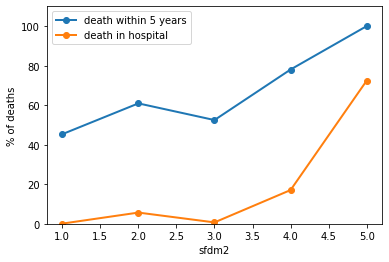

In [47]:
plt.plot(table1.index[1:], table1.loc[1:,'death'], '-o', linewidth=2.0, label='death within 5 years')
plt.plot(table1.index[1:], table1.loc[1:,'hospdead'], '-o', linewidth=2.0, label='death in hospital')
plt.xlabel('sfdm2')
plt.ylabel('% of deaths')
plt.ylim(0, 110)
plt.legend()
plt.show()

Возрастание не монотонное. Так что, скорее всего, sfdm2 - не очень хорошая оценка уровня функциональных нарушений. Прогнозировать буду первые две колонки.

In [48]:
# y.pivot_table(index='sfdm2', columns='death', aggfunc='count', fill_value=0)

#### Признаки

In [49]:
# data = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/features.csv", encoding='utf-8', sep=',')

In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9105 entries, 0 to 9104
Data columns (total 44 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       9105 non-null   float32 
 1   sex       9105 non-null   int8    
 2   dzgroup   9105 non-null   category
 3   dzclass   9105 non-null   category
 4   num.co    9105 non-null   int8    
 5   edu       9105 non-null   float32 
 6   income    9105 non-null   int8    
 7   scoma     9104 non-null   float32 
 8   charges   9105 non-null   float32 
 9   totcst    9105 non-null   float32 
 10  totmcst   5630 non-null   float32 
 11  avtisst   9023 non-null   float32 
 12  race      9063 non-null   category
 13  sps       9104 non-null   float32 
 14  aps       9104 non-null   float32 
 15  surv2m    9104 non-null   float32 
 16  surv6m    9104 non-null   float32 
 17  hday      9105 non-null   int16   
 18  diabetes  9105 non-null   int8    
 19  dementia  9105 non-null   int8    
 20  ca      

In [11]:
merged_data = pd.merge(data, y, left_index=True, right_index=True)

In [69]:
pd.set_option('display.max_columns', None)

In [53]:
merged_data.groupby('death').mean()

,age,sex,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,d.time,slos,hospdead,sfdm2
death,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,58.566974,1.460399,1.733815,11.761981,1.070937,7.163567,62158.303607,32359.600390,30071.676779,20.338355,23.264515,33.036157,0.753734,0.660105,3.548554,0.188361,0.021006,0.240358,0.751921,0.669641,0.088154,18.856945,85.830923,12.412882,97.333815,23.241736,37.157221,239.178736,2.932660,2.323710,1.705277,137.730716,7.416344,159.542563,31.687284,2199.979650,0.924945,1.180219,1.435150,1060.220041,20.535124,0.000000,0.906680
1,64.563337,1.426222,1.931785,11.740487,0.923077,14.351290,58985.216605,30127.061716,28188.242566,23.670945,26.585063,39.734677,0.580664,0.454517,4.798742,0.198516,0.037897,0.688599,0.555796,0.419403,0.473956,12.581298,83.944758,12.317020,97.073758,23.371774,37.078104,239.704004,2.959199,2.662266,1.801821,137.492581,7.414875,160.075814,32.753455,2186.378821,1.308314,1.869891,2.100474,206.000161,16.611676,0.380584,2.956136


In [54]:
num_features = data.select_dtypes(exclude='category')
num_features.describe()

,age,sex,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,d.time,slos
count,9105.000000,9105.000000,9105.000000,7471.000000,9105.000000,9104.000000,8.933000e+03,8217.000000,5630.000000,9023.000000,9104.000000,9104.000000,9104.000000,9104.000000,9105.000000,9105.000000,9105.000000,9105.000000,7456.000000,7472.000000,9105.000000,9075.000000,9104.000000,8893.000000,9104.000000,9104.000000,9104.000000,6780.000000,5733.000000,6504.000000,9038.000000,9104.000000,6821.000000,4605.000000,4753.000000,4243.000000,3464.000000,6238.000000,9105.000000,9105.000000,9105.000000
mean,62.650823,1.437122,1.868644,11.747691,0.970236,12.058546,5.999579e+04,30825.867785,28828.877827,22.610928,25.525872,37.597979,0.635870,0.520096,4.400000,0.195277,0.032510,0.545634,0.618769,0.499679,0.350906,14.582590,84.546408,12.347677,97.156711,23.330294,37.103341,239.529070,2.950520,2.554463,1.770961,137.568541,7.415364,159.873398,32.349463,2191.546047,1.157910,1.637384,1.888272,478.449863,17.863042
std,15.593710,0.496058,1.344409,3.447743,1.617910,24.636694,1.026488e+05,45780.821015,43604.261888,13.233248,9.899377,19.903852,0.248175,0.253343,9.126811,0.396436,0.177359,0.810010,0.298367,0.304367,0.477280,19.944216,27.687692,9.266329,31.559292,9.573801,1.251796,109.665593,0.875944,5.318448,1.686041,6.029326,0.080563,88.391541,26.792288,1455.245777,1.739672,2.231358,2.003763,560.383272,22.006440
min,18.041990,1.000000,0.000000,0.000000,-1.000000,0.000000,1.169000e+03,0.000000,-102.719970,1.000000,0.199982,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-88.000000,0.000000,0.000000,0.000000,0.000000,31.699220,12.000000,0.399963,0.099991,0.099991,110.000000,6.829102,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
25%,52.797000,1.000000,1.000000,10.000000,-1.000000,0.000000,9.740000e+03,5929.566400,5177.404300,12.000000,19.000000,23.000000,0.507690,0.342957,1.000000,0.000000,0.000000,0.000000,0.500000,0.200000,0.000000,4.000000,63.000000,7.000000,72.000000,18.000000,36.195310,155.093750,2.399902,0.500000,0.899902,134.000000,7.379883,103.000000,14.000000,1165.500000,0.000000,0.000000,0.000000,26.000000,6.000000
50%,64.856990,1.000000,2.000000,12.000000,1.000000,0.000000,2.502400e+04,14452.734000,13223.500000,19.500000,23.898438,34.000000,0.715942,0.574951,1.000000,0.000000,0.000000,0.000000,0.700000,0.500000,0.000000,9.000000,77.000000,10.599609,100.000000,24.000000,36.695310,224.000000,2.899902,0.899902,1.199951,137.000000,7.419922,135.000000,23.000000,1968.000000,0.000000,1.000000,1.000000,233.000000,11.000000
75%,73.998960,2.000000,3.000000,14.000000,2.000000,9.000000,6.459800e+04,36087.938000,34223.602500,31.666656,30.199219,49.000000,0.825928,0.725952,3.000000,0.000000,0.000000,1.000000,0.900000,0.750000,1.000000,17.000000,107.000000,15.298828,120.000000,28.000000,38.195310,304.750000,3.599609,1.899902,1.899902,141.000000,7.469727,188.000000,42.000000,3000.000000,2.000000,3.000000,3.000000,761.000000,20.000000
max,101.847960,2.000000,9.000000,31.000000,4.000000,100.000000,1.435423e+06,633212.000000,710682.000000,83.000000,99.187500,143.000000,0.969971,0.947998,148.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,285.000000,195.000000,200.000000,300.000000,90.000000,41.695310,890.375000,29.000000,63.000000,21.500000,181.000000,7.769531,1092.000000,300.000000,9000.000000,7.000000,7.000000,7.073242,2029.000000,343.000000


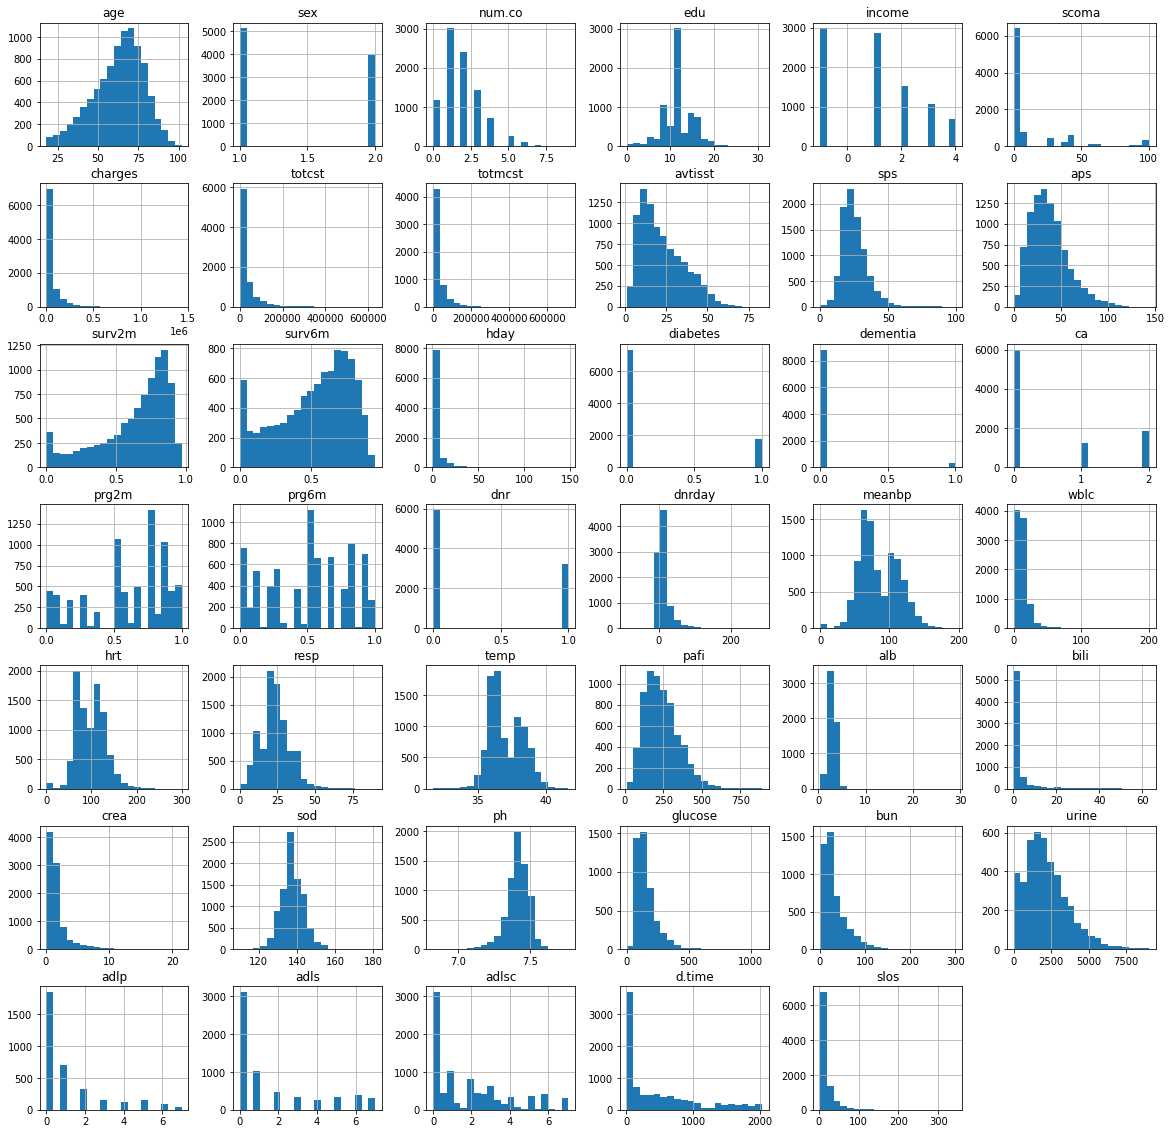

In [55]:
num_features.hist(figsize=(20,20), bins=20);

1. Признак "age", возраст. Пропусков нет, явных ошибок нет. Позднее нужно будет отмасштабировать.

2. Признак 'sex', пол. Пропусков нет, явных ошибок нет.

3. Признак 'num.co', количество сопутствующих заболеваний. Пропусков, явных ошибок нет. Позднее нужно будет отмасштабировать.

4. 'edu', Сколько лет человек учился. Скорее всего, бесполезный признак.

In [56]:
data[['edu', 'charges', 'totcst']].median()

edu           12.000
charges    25024.000
totcst     14452.734
dtype: float64

In [57]:
data[['edu', 'charges', 'totcst']] = data[['edu', 'charges', 'totcst']].fillna(data[['edu', 'charges', 'totcst']].median())
# data[['edu', 'charges', 'totcst', 'avtisst', 'meanbp']]
# prg2m, prg6m

In [58]:
data['edu'].isna().sum()

0

5. income, уровень дохода.Пропусков, явных ошибок нет.

In [59]:
# merged_data[['sfdm2','death', 'hospdead', 'income']].groupby('income').mean()*100

6. scoma, SUPPORT Coma Score на третий день госпитализации. Явных ошибок нет. Признак явно коррелирует с целевой переменной.

In [60]:
data.loc[data['scoma'].isna()]

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,race,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,d.time,slos
5393,62.52197,1,ARF/MOSF w/Sepsis,ARF/MOSF,2,16.0,4,NaN,25024.0,14452.734,NaN,NaN,white,NaN,NaN,NaN,NaN,1,1,0,0,NaN,NaN,0,NaN,55.0,13.099609,110.0,25.0,35.89844,NaN,NaN,NaN,1.799805,133.0,NaN,259.0,60.0,3170.0,NaN,0.0,0.0,3,3


Один пропуск, причем для этого пациента не известно также много других признаков. Строчку проще удалить.

In [61]:
merged_data[['scoma','death', 'hospdead', 'sfdm2']].groupby('scoma').mean()*100

,death,hospdead,sfdm2
scoma,,,
0.0,65.255429,16.966099,191.454460
9.0,67.513369,27.005348,258.422460
26.0,70.159453,39.179954,269.931663
37.0,68.127490,45.019920,307.171315
41.0,71.134021,48.969072,321.649485
44.0,75.438596,50.877193,342.606516
55.0,85.714286,60.204082,363.265306
61.0,83.593750,60.937500,381.250000
89.0,90.740741,66.666667,427.777778


In [62]:
# data['scoma'].value_counts()

7,8,9. charges, totcst, totmcst, больничные затраты, суммарное отношение цен к затратам и общая микростоимость(?). Два последних показателя сильно скоррелированы, последний можно отбросить.

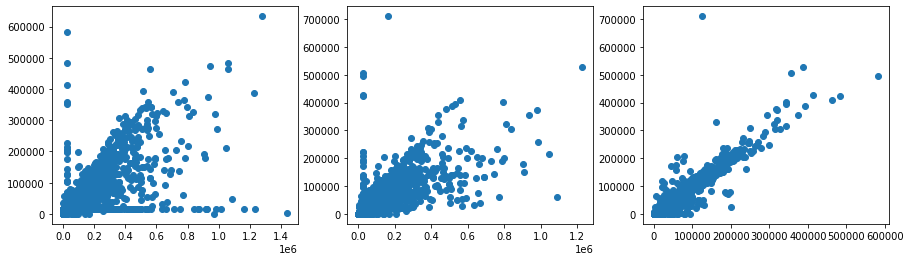

In [63]:
plt.figure(figsize = (15, 4))
plt.subplot(131)
plt.scatter(data['charges'], data['totcst'])

plt.subplot(132)
plt.scatter(data['charges'], data['totmcst'])
plt.subplot(133)
plt.scatter(data['totcst'], data['totmcst'])

plt.show()

totcst и totmcst сильно скоррелированы, оба параметра оставлять не нужно.

10. avtisst средний за 3-25 дни  Therapeutic Intervention Scoring System (TISS) score. Заполнить пропуски, отмасштабировать

11. sps, SUPPORT physiology score на 3 день госпитализации
12. aps, APACHE III day 3 physiology score
13. surv2m оценка выживания через 2 месяца по модели SUPPORT
14. surv6m оценка выживания через 6 месяцев	по модели SUPPORT

15. день госпитализации, на который пациента включили в исследование. По этому столбцу можно фильтровать, но не брать для построения модели.

16.17.18. diabetes, dementia, ca наличие у пациента диабета, деменции, онкологии

19.20. prg2m, prg6m оценка выживания через 2 месяца и 6 месяцев, сделанная врачом

21, 22. dnr, dnrday - наличие приказа не реанимировать и день подписания такого приказа.

23. meanbp - среднее артериальное давление, измеренное на 3 день госпитализации. Можно пробовать разбить на 2 категории, т.к. распределение двугорбое.

24. wblc -  концентрация лейкоцитов (тыс/мкл), на 3 день госпитализации

In [64]:
merged_data.loc[merged_data['wblc']==0]

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,race,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,d.time,slos,death,hospdead,sfdm2
5953,60.68698,2,MOSF w/Malig,ARF/MOSF,1,15.0,3,37.0,67389.0,50678.5940,23929.0780,50.000000,white,34.500000,53.0,0.155975,0.075989,10,0,0,1,0.80,0.700,1,16.0,114.0,0.0,136.0,32.0,39.59375,293.3125,2.299805,2.399902,0.500000,137.0,7.539062,NaN,NaN,NaN,NaN,1.0,1.000000,17,17,1,1,5
6048,54.14600,2,MOSF w/Malig,ARF/MOSF,1,12.0,-1,0.0,27282.0,19477.1720,9371.7270,21.500000,white,36.593750,45.0,0.264954,0.157990,19,0,0,1,0.95,0.950,0,8.0,91.0,0.0,140.0,28.0,39.00000,NaN,2.500000,1.399902,0.799927,125.0,NaN,NaN,NaN,NaN,0.0,6.0,6.000000,524,8,1,0,1
6105,74.38696,2,MOSF w/Malig,ARF/MOSF,3,12.0,1,9.0,11969.0,8219.4920,8524.7890,32.000000,white,37.195312,54.0,0.200989,0.107986,1,0,0,2,0.50,0.500,0,11.0,110.0,0.0,108.0,30.0,36.00000,NaN,2.000000,1.099854,1.799805,127.0,NaN,NaN,NaN,NaN,7.0,6.0,6.000000,11,11,1,1,5
6193,51.04199,1,MOSF w/Malig,ARF/MOSF,1,14.0,4,0.0,52045.0,35465.7800,38358.0300,28.500000,white,32.898438,39.0,0.396973,0.277954,11,0,0,1,0.70,0.300,0,30.0,94.0,0.0,104.0,24.0,36.69531,NaN,2.500000,3.199707,1.099854,127.0,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,944,30,1,0,3
6206,70.10498,2,MOSF w/Malig,ARF/MOSF,3,10.0,2,0.0,15832.0,11012.5160,12351.3125,20.333328,white,27.199219,50.0,0.543945,0.429993,1,0,0,2,0.60,0.300,0,16.0,65.0,0.0,74.0,22.0,35.79688,341.3750,2.599609,3.000000,1.099854,138.0,7.409180,NaN,NaN,NaN,0.0,1.0,1.000000,418,16,1,0,1
6386,51.68198,1,MOSF w/Malig,ARF/MOSF,1,14.0,3,0.0,12063.0,7601.9180,8637.7660,30.000000,white,33.796875,50.0,0.448975,0.328979,2,0,0,1,0.10,0.001,0,10.0,93.0,0.0,136.0,24.0,39.79688,NaN,2.000000,0.599976,1.599854,130.0,NaN,NaN,NaN,NaN,NaN,NaN,3.039551,662,10,1,0,1
6501,51.15698,1,MOSF w/Malig,ARF/MOSF,1,8.0,2,0.0,3387.0,2218.2695,2290.5488,20.000000,white,37.796875,59.0,0.271973,0.164978,1,0,0,2,NaN,NaN,1,2.0,75.0,0.0,130.0,36.0,37.19531,120.0000,2.899902,0.500000,1.500000,142.0,7.209961,NaN,NaN,NaN,NaN,NaN,2.916992,3,3,1,1,5
6505,41.26498,1,MOSF w/Malig,ARF/MOSF,6,12.0,1,9.0,88324.0,57915.2200,69530.5600,59.250000,white,42.195312,77.0,0.206970,0.112991,1,0,0,1,0.50,0.500,1,27.0,160.0,0.0,116.0,8.0,34.19531,210.0000,2.699707,9.199219,1.500000,143.0,7.469727,NaN,NaN,NaN,NaN,0.0,0.000000,27,27,1,1,5
6707,50.10797,2,MOSF w/Malig,ARF/MOSF,1,13.0,2,9.0,59953.0,32717.1100,41005.7800,30.333328,white,28.597656,35.0,0.469971,0.351990,14,0,0,1,0.50,0.500,0,20.0,74.0,0.0,101.0,20.0,35.79688,NaN,2.599609,0.500000,0.899902,133.0,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,448,20,1,0,3
8091,49.98499,1,COPD,COPD/CHF/Cirrhosis,5,12.0,1,0.0,3431.0,2554.0234,2946.4883,21.000000,white,19.796875,56.0,0.917969,0.861939,1,1,0,0,NaN,NaN,0,5.0,77.0,0.0,118.0,28.0,36.79688,226.0625,NaN,0.500000,1.299805,139.0,7.339844,NaN,NaN,NaN,0.0,NaN,0.494800,678,5,1,0,-1


25. hrt - частота сердечных сокращений в 3 день госпитализации

In [65]:
merged_data.loc[merged_data['hrt']==0]

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,race,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,d.time,slos,death,hospdead,sfdm2
96,89.58795,1,ARF/MOSF w/Sepsis,ARF/MOSF,2,NaN,-1,100.0,19238.0,9710.9060,NaN,34.000000,white,54.898438,80.0,0.000000,0.000000,1,0,0,2,NaN,NaN,0,4.0,33.0,13.699219,0.0,0.0,38.50000,122.0000,2.299805,0.500000,1.000000,130.0,7.289062,NaN,NaN,NaN,NaN,NaN,5.568359,4,4,1,1,5
164,20.83199,1,MOSF w/Malig,ARF/MOSF,1,NaN,-1,0.0,392950.0,197040.1200,NaN,37.000000,white,88.390625,106.0,0.000000,0.000000,63,0,0,1,NaN,NaN,1,1.0,0.0,5.799805,0.0,0.0,37.79688,130.0000,4.000000,10.500000,3.599609,132.0,7.279297,NaN,NaN,NaN,NaN,NaN,1.141602,3,3,1,1,5
796,72.35297,2,CHF,COPD/CHF/Cirrhosis,1,13.0,2,100.0,25184.0,11041.5940,NaN,39.000000,white,38.398438,40.0,0.037994,0.003000,1,0,0,0,NaN,NaN,0,3.0,48.0,7.299805,0.0,12.0,37.19531,388.0000,3.199707,1.299805,1.399902,129.0,7.449219,NaN,NaN,NaN,NaN,NaN,3.769531,3,3,1,1,5
816,52.75598,2,ARF/MOSF w/Sepsis,ARF/MOSF,2,NaN,-1,100.0,25511.0,14848.5470,NaN,25.000000,white,48.898438,73.0,0.004999,0.001000,1,1,0,0,0.10,0.001,0,3.0,38.0,15.398438,0.0,0.0,38.19531,186.0000,NaN,NaN,0.799927,156.0,7.069336,NaN,NaN,NaN,NaN,NaN,3.945312,3,3,1,1,5
918,45.04300,1,ARF/MOSF w/Sepsis,ARF/MOSF,3,12.0,1,55.0,30354.0,12436.8125,16955.6880,29.000000,white,85.187500,104.0,0.000000,0.000000,1,0,0,0,0.10,0.050,1,2.0,5.0,14.500000,0.0,5.0,38.79688,120.0000,3.299805,1.799805,4.399414,124.0,7.719727,100.0,92.0,275.0,NaN,NaN,1.614258,3,3,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7093,82.41998,1,ARF/MOSF w/Sepsis,ARF/MOSF,2,20.0,3,0.0,35216.0,24531.2030,27599.6100,22.000000,white,21.398438,36.0,0.665894,0.568970,9,0,0,1,0.65,0.550,0,20.0,0.0,14.699219,0.0,16.0,37.69531,55.0000,1.699951,0.599976,2.899902,121.0,7.269531,257.0,38.0,NaN,0.0,NaN,0.494751,823,20,0,0,2
7241,64.23297,2,COPD,COPD/CHF/Cirrhosis,4,6.0,1,0.0,5989.0,4009.6348,4146.2695,4.000000,white,14.000000,18.0,0.894897,0.824951,1,0,0,1,0.80,0.800,0,6.0,0.0,18.500000,0.0,8.0,33.59375,260.0000,2.199707,10.298828,3.699707,144.0,7.419922,74.0,60.0,3.0,1.0,NaN,1.166748,710,6,0,0,1
7635,59.38397,2,Lung Cancer,Cancer,3,10.0,1,0.0,17749.0,11602.1875,14856.5390,12.333328,white,33.695312,25.0,0.279968,0.042999,1,0,0,2,0.80,0.400,1,-1.0,0.0,14.500000,0.0,0.0,38.89844,79.0000,2.599609,1.199951,6.799805,140.0,7.029297,136.0,45.0,0.0,4.0,5.0,5.000000,91,15,1,0,3
8704,46.57599,2,ARF/MOSF w/Sepsis,ARF/MOSF,0,NaN,-1,0.0,100646.0,68337.1250,66688.6250,35.000000,white,39.500000,60.0,0.588989,0.479980,1,0,0,0,0.90,0.900,0,37.0,43.0,10.599609,0.0,0.0,38.39844,133.3125,NaN,1.399902,2.500000,132.0,7.379883,345.0,38.0,1300.0,NaN,NaN,2.007812,811,37,0,0,-1


ЧСС = 0 у выживших явная ошибка, но по не целевым признакам ее сложно поймать

26.resp -  частота дыхательных движений на 3 день

In [66]:
merged_data.loc[merged_data['resp']==0]

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,totmcst,avtisst,race,sps,aps,surv2m,surv6m,hday,diabetes,dementia,ca,prg2m,prg6m,dnr,dnrday,meanbp,wblc,hrt,resp,temp,pafi,alb,bili,crea,sod,ph,glucose,bun,urine,adlp,adls,adlsc,d.time,slos,death,hospdead,sfdm2
96,89.58795,1,ARF/MOSF w/Sepsis,ARF/MOSF,2,NaN,-1,100.0,19238.0,9710.9060,NaN,34.000000,white,54.898438,80.0,0.000000,0.000000,1,0,0,2,NaN,NaN,0,4.0,33.0,13.699219,0.0,0.0,38.50000,122.00000,2.299805,0.500000,1.000000,130.0,7.289062,NaN,NaN,NaN,NaN,NaN,5.568359,4,4,1,1,5
164,20.83199,1,MOSF w/Malig,ARF/MOSF,1,NaN,-1,0.0,392950.0,197040.1200,NaN,37.000000,white,88.390625,106.0,0.000000,0.000000,63,0,0,1,NaN,NaN,1,1.0,0.0,5.799805,0.0,0.0,37.79688,130.00000,4.000000,10.500000,3.599609,132.0,7.279297,NaN,NaN,NaN,NaN,NaN,1.141602,3,3,1,1,5
816,52.75598,2,ARF/MOSF w/Sepsis,ARF/MOSF,2,NaN,-1,100.0,25511.0,14848.5470,NaN,25.000000,white,48.898438,73.0,0.004999,0.001000,1,1,0,0,0.1,0.001,0,3.0,38.0,15.398438,0.0,0.0,38.19531,186.00000,NaN,NaN,0.799927,156.0,7.069336,NaN,NaN,NaN,NaN,NaN,3.945312,3,3,1,1,5
1503,55.43298,2,ARF/MOSF w/Sepsis,ARF/MOSF,1,12.0,2,0.0,35245.0,16080.6330,18295.328,18.000000,white,20.296875,33.0,0.876953,0.832886,1,0,0,0,0.9,0.800,0,9.0,0.0,24.199219,0.0,0.0,36.19531,274.25000,1.199951,10.099609,2.799805,142.0,7.349609,NaN,92.0,14.0,NaN,6.0,6.000000,441,9,0,0,3
1543,65.95996,1,MOSF w/Malig,ARF/MOSF,3,12.0,1,100.0,68139.0,26086.8600,30802.766,35.000000,white,33.093750,60.0,0.042000,0.011999,1,0,0,1,0.2,0.500,0,8.0,62.0,17.500000,55.0,0.0,36.19531,206.65625,NaN,1.299805,2.399902,142.0,7.409180,139.0,39.0,5210.0,NaN,6.0,6.000000,8,8,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6613,80.26794,1,ARF/MOSF w/Sepsis,ARF/MOSF,1,12.0,1,44.0,19288.0,8867.4920,10029.359,64.000000,white,91.093750,109.0,0.000000,0.000000,3,0,0,0,0.1,0.001,1,3.0,0.0,19.398438,0.0,0.0,36.69531,54.00000,2.000000,3.599609,4.399414,130.0,7.149414,NaN,NaN,NaN,NaN,7.0,7.000000,3,3,1,1,5
6745,60.64899,2,COPD,COPD/CHF/Cirrhosis,4,8.0,2,0.0,6610.0,4424.2110,4562.789,3.000000,white,17.398438,21.0,0.878906,0.797974,1,1,0,1,0.9,0.800,0,7.0,0.0,12.199219,0.0,0.0,36.09375,157.00000,NaN,NaN,0.899902,143.0,7.239258,141.0,15.0,3040.0,4.0,NaN,3.183105,92,7,1,0,1
7068,76.66498,1,ARF/MOSF w/Sepsis,ARF/MOSF,3,9.0,-1,0.0,43677.0,29397.1720,32307.406,30.333328,white,25.296875,33.0,0.683960,0.589966,7,1,0,0,0.8,0.800,0,20.0,128.0,28.097656,147.0,0.0,38.50000,163.25000,NaN,NaN,0.599976,134.0,7.379883,101.0,13.0,3000.0,NaN,3.0,3.000000,278,20,1,0,1
7635,59.38397,2,Lung Cancer,Cancer,3,10.0,1,0.0,17749.0,11602.1875,14856.539,12.333328,white,33.695312,25.0,0.279968,0.042999,1,0,0,2,0.8,0.400,1,-1.0,0.0,14.500000,0.0,0.0,38.89844,79.00000,2.599609,1.199951,6.799805,140.0,7.029297,136.0,45.0,0.0,4.0,5.0,5.000000,91,15,1,0,3


частота дыхательных движений равная 0 также, по-видимому, ошибка

temp, pafi,	alb, bili, crea, sod, ph, glucose, bun, urine - результаты анализов на 3й день госпитализации
Рекомендация авторов по заполнению пропусков:

Baseline Variable	Normal Fill-in Value
- Serum albumin (alb)	3.5
- PaO2/FiO2 ratio (pafi) 	333.3
- Bilirubin (bili)	1.01
- Creatinine (crea)	1.01
- bun	6.51
- White blood count (wblc)	9 (thousands)
- Urine output (urine)	2502

У температуры двугорбое распределение. По-видимому, горбы соответствуют наличию или отсутствию лихорадки. Можно пробовать разбивать на 2 категории.
PaO2/FiO2 рекомендуют разбивать на категории.
https://www.pinsonandtang.com/resources/pf-ratio/

adlp - Индекс Activities of Daily Living (ADL), заполненный пациентом
adls - Индекс Activities of Daily Living (ADL), заполненный ответственным за пациента человеком (членом семьи)
adlsc - Индекс Activities of Daily Living (ADL), заполненный ответственным за пациента человеком (членом семьи), откалиброванный по заполняющему

#### Категориальные признаки

In [73]:
data['dzgroup'].value_counts() # основной диагноз

ARF/MOSF w/Sepsis    3515
CHF                  1387
COPD                  967
Lung Cancer           908
MOSF w/Malig          712
Coma                  596
Colon Cancer          512
Cirrhosis             508
Name: dzgroup, dtype: int64

In [74]:
merged_data[['dzgroup', 'death']].groupby('dzgroup').mean()*100

,death
dzgroup,
ARF/MOSF w/Sepsis,59.061166
CHF,60.850757
COPD,58.014478
Cirrhosis,64.763780
Colon Cancer,83.398438
Coma,81.208054
Lung Cancer,91.740088
MOSF w/Malig,90.870787


In [75]:
data['dzclass'].value_counts() # класс основного диагноза

ARF/MOSF              4227
COPD/CHF/Cirrhosis    2862
Cancer                1420
Coma                   596
Name: dzclass, dtype: int64

In [76]:
merged_data[['dzclass', 'death']].groupby('dzclass').mean()*100

,death
dzclass,
ARF/MOSF,64.419210
COPD/CHF/Cirrhosis,60.587002
Cancer,88.732394
Coma,81.208054


Оставлю только основной диагноз, без объединения по классам.

In [77]:
data['race'].value_counts()

white       7191
black       1391
hispanic     290
other        112
asian         79
Name: race, dtype: int64

### Построение модели

In [77]:
y = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/target.csv", encoding='utf-8', sep=',')
data = pd.read_csv("C:/Users/li_le/geekbrains_study/диплом/features.csv", encoding='utf-8', sep=',')

In [78]:
data = reduce_mem(data)

Memory usage of dataframe is: 3.056610107421875 Mb
Memory usage after optimization is: 1.2165145874023438 MB
Decreased by 60.20053115546281 %


In [312]:
x_tr, x_test, y_tr, y_test = train_test_split(data, y, test_size=0.3, shuffle=True, random_state=13)

x_train, x_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.3, random_state=7)

In [82]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [83]:
def pafi_to_cat(x):
    if x > 400:
        return 0
    elif x > 300:
        return 1
    elif x > 250:
        return 2
    elif x > 200:
        return 3
    else:
        return 4

In [104]:
#       Для построения модели  исключаю признаки 'dzclass', 'charges', 'totcst' - по причинам, названным выше
# 'surv2m', 'surv6m', 'prg2m', 'prg6m', - оценки выживаемости пациентов по другой модели и по мнению врачей
# из 'adls', 'adlsc' оставляю только 'adlsc' -  откалиброванный Индекс Activities of Daily Living (ADL),
# заполненный ответственным за пациента человеком (членом семьи),
# 'dnr', 'dnrday', - наличие договора об отказе от реанимации и день подписания договора. Это тоже в какой-то степени готовая оценка
# 'd.time', 'slos', 'hday' - параметры, не имеющие прямого отношения к состоянию пациента
selected_features = ['age', 'sex', 'dzgroup', 'num.co', 'edu','income', 'scoma','totmcst', 'avtisst',
                     'race', 'sps', 'aps', 'diabetes', 'dementia', 'ca' , 'meanbp', 'wblc', 'hrt',
                     'resp', 'temp','pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun',
                     'urine','adlp', 'adlsc']

# То же, что selected_features, но без 'dzgroup' и 'race'. Они заменятся на dummy позже

selected_features2 = ['age', 'sex', 'num.co', 'edu','income', 'scoma','totmcst', 'avtisst',
                      'sps', 'aps', 'diabetes', 'dementia', 'ca' , 'meanbp', 'wblc', 'hrt',
                     'resp', 'temp','pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun',
                     'urine','adlp', 'adlsc']        
               
               
#  Полный список признаков       
#         ['age', 'sex', 'dzgroup', 'dzclass', 'num.co', 'edu', 'income', 'scoma',
#        'charges', 'totcst', 'totmcst', 'avtisst', 'race', 'sps', 'aps',
#        'surv2m', 'surv6m', 'hday', 'diabetes', 'dementia', 'ca', 'prg2m',
#        'prg6m', 'dnr', 'dnrday', 'meanbp', 'wblc', 'hrt', 'resp', 'temp',
#        'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 'glucose', 'bun', 'urine',
#        'adlp', 'adls', 'adlsc', 'd.time', 'slos']

In [180]:
class DataPreprocessing(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.modes = None
        
        
    def fit(self, x, y=None):
        self.modes = x.mode().loc[0]
        return self
        
       
    def transform(self, x):
        
        # 1. Пропуски
        
        x['edu_nan'] = 0
        x.loc[x['edu'].isna(), 'edu_nan'] = 1
        
#         x['prg2m_nan'] = 0
#         x.loc[x['prg2m'].isna(), 'prg2m_nan'] = 1
        
#         x['prg6m_nan'] = 0
#         x.loc[x['prg6m'].isna(), 'prg6m_nan'] = 1
        
        x['wblc_nan'] = 0
        x.loc[x['wblc'].isna(), 'wblc_nan'] = 1
        
        x['pafi_nan'] = 0
        x.loc[x['pafi'].isna(), 'pafi_nan'] = 1
        
        x['alb_nan'] = 0
        x.loc[x['alb'].isna(), 'alb_nan'] = 1
        
        x['bili_nan'] = 0
        x.loc[x['bili'].isna(), 'bili_nan'] = 1
        
        x['ph_nan'] = 0
        x.loc[x['ph'].isna(), 'ph_nan'] = 1
        
        x['glucose_nan'] = 0
        x.loc[x['glucose'].isna(), 'glucose_nan'] = 1
        
        x['bun_nan'] = 0
        x.loc[x['bun'].isna(), 'bun_nan'] = 1
        
        x['urine_nan'] = 0
        x.loc[x['urine'].isna(), 'urine_nan'] = 1
        
        x['adlp_nan'] = 0
        x.loc[x['adlp'].isna(), 'adlp_nan'] = 1
        
        x['adls_nan'] = 0
        x.loc[x['adls'].isna(), 'adls_nan'] = 1
        
        # Baseline Variable Normal Fill-in Value       моды

        # Serum albumin (alb) 3.5             2.5
        # PaO2/FiO2 ratio (pafi) 333.3        200.0
        # Bilirubin (bili) 1.01               0.399963
        # Creatinine (crea) 1.01              0.899902
        # bun 6.51                             11
        # White blood count (wblc) 9 (thousands) 6.799805
        # Urine output (urine) 2502             0
        
        x['alb'] = x['alb'].fillna(3.5)
        x['pafi'] =x['pafi'].fillna(333.3)
        x['bili'] = x['bili'].fillna(1.01)
        x['crea'] = x['crea'].fillna(1.01)
        x['bun'] = x['bun'].fillna(6.51)
        x['wblc'] = x['wblc'].fillna(9)
        x['urine'] = x['urine'].fillna(2502)
        x[selected_features] = x[selected_features].fillna(self.modes)

               
        # 2. Выбросы (outliers)
#         В первом приближении не обрабатываю. Достаточно сложно сказать каких значений анализов точно не может быть у пациента
#         в критическом состоянии   


        # 3. категориальные признаки
#         x['sex'] = x['sex'].map({'male': 1, 'female': 2})
#         x['sex'] = x['sex'].astype('int8')
        
#         x['income'] = x['income'].map({'under $11k':1, '$11-$25k':2, '$25-$50k': 3, '>$50k':4})
#         x['income'] = x['income'].astype('str').astype('int8')
        
#         x['ca'] = x['ca'].map({'no': 0, 'yes': 1, 'metastatic': 2}).astype('int8')
        
#         x['dnr'] = x['dnr'].apply(lambda x: 1 if x=='dnr after sadm' or x=='dnr before sadm' else 0)
#         x['dnr'] = x['dnr'].astype('int8')
        
        x['meanbp_cat'] = x['meanbp'].apply(lambda a: 0 if a < 95 else 1)
        x['fever'] = x['temp'].apply(lambda a: 0 if a < 37.5 else 1)
        x['pafi_cat'] = x['pafi'].apply(lambda a: pafi_to_cat(a))
    
        x = pd.concat([x, pd.get_dummies(x['race'])], axis=1)
        x = pd.concat([x, pd.get_dummies(x['dzgroup'])], axis=1)
        
#         4. масштабирование

        tmp = x[selected_features].select_dtypes(exclude=['category', 'object']).nunique()>3
        feature_to_scale = [el for el in tmp.index if tmp[el]]
        x[feature_to_scale] = standard_scale(x[feature_to_scale])
         
        return x


In [183]:
dp = DataPreprocessing()

In [313]:
x_test = dp.fit_transform(x_test)
x_train = dp.fit_transform(x_train)
x_valid = dp.fit_transform(x_valid)

In [185]:
dum_fiatures = np.concatenate((x_train['race'].unique(), x_train['dzgroup'].unique())) 
dum_fiatures

array(['white', 'black', 'asian', 'hispanic', 'other', 'Lung Cancer',
       'Coma', 'ARF/MOSF w/Sepsis', 'Colon Cancer', 'CHF', 'MOSF w/Malig',
       'COPD', 'Cirrhosis'], dtype=object)

In [186]:
error_features = [el for el in x_train.columns if el.endswith('_nan')]

In [156]:
new_features = ['meanbp_cat', 'fever', 'pafi_cat'] + list(dum_fiatures) + error_features

In [157]:
model1 = RandomForestClassifier(random_state=7)

In [158]:
model1.fit(x_train[selected_features2 + new_features], y_train['death'])

RandomForestClassifier(random_state=7)

In [160]:
preds = model1.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds3)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.500000, F-Score=0.828, Precision=0.759, Recall=0.911


In [105]:
# model1.fit(x_train[selected_features2 + list(dum_fiatures)], y_train['death'])

RandomForestClassifier(random_state=7)

In [161]:
# preds = model1.predict_proba(x_valid[selected_features2 + list(dum_fiatures)])[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds)

# fscore = (2 * precision * recall) / (precision + recall)

# ix = np.argmax(fscore)
# print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
#                                                                         fscore[ix],
#                                                                         precision[ix],
#                                                                         recall[ix]))

In [162]:
model1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [379]:
params = params={'max_features':[5, 10, 15, 20],
        'min_samples_leaf':[1, 2, 3, 4],
        'max_depth':[5, 10, 15]
        }
grid = GridSearchCV(model1, param_grid=params, refit=False)
search = grid.fit(x_train[selected_features2 + new_features], y_train['death'])
search.best_params_

{'max_depth': 10, 'max_features': 15, 'min_samples_leaf': 2}

In [381]:
model2 = RandomForestClassifier(max_depth=10, max_features=15, min_samples_leaf=2, random_state=7)

In [382]:
model2.fit(x_train[selected_features2 + new_features], y_train['death'])

RandomForestClassifier(max_depth=10, max_features=15, min_samples_leaf=2,
                       random_state=7)

In [383]:
preds2 = model2.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds2)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.484742, F-Score=0.830, Precision=0.754, Recall=0.923


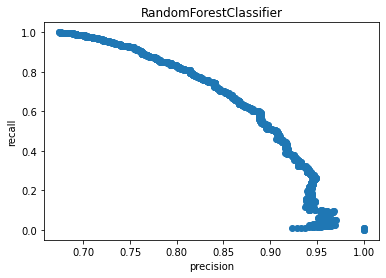

In [384]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('RandomForestClassifier')
plt.show()

In [171]:
feature_importances = pd.DataFrame(model2.feature_importances_, columns=['coefficient'], index=selected_features2 + new_features)
feature_importances.sort_values(by='coefficient', inplace=True, ascending=False)
# selected_features = feature_importances.head(60)

In [238]:
imp_features = feature_importances.head(30).index
imp_features

Index(['age', 'ca', 'avtisst', 'aps', 'sps', 'adlsc', 'ARF/MOSF w/Sepsis',
       'num.co', 'wblc', 'totmcst', 'meanbp', 'pafi', 'hrt', 'scoma', 'temp',
       'glucose', 'crea', 'urine', 'bun', 'sod', 'Lung Cancer', 'ph', 'alb',
       'bili', 'resp', 'edu', 'income', 'MOSF w/Malig', 'bun_nan',
       'glucose_nan'],
      dtype='object')

In [244]:
feature_importances


,coefficient
age,0.090142
ca,0.080412
avtisst,0.070215
aps,0.066874
sps,0.061761
adlsc,0.041838
ARF/MOSF w/Sepsis,0.031807
num.co,0.030230
wblc,0.028753
totmcst,0.028143


In [243]:
params = params={'max_features':[5, 10, 15, 20],
        'min_samples_leaf':[2, 3, 4],
        'max_depth':[5, 10, 15, None]
        }
grid = GridSearchCV(model1, param_grid=params, refit=False)
search = grid.fit(x_train[imp_features], y_train['death'])
search.best_params_

{'max_depth': 15, 'max_features': 5, 'min_samples_leaf': 3}

In [240]:
model3 = RandomForestClassifier(max_depth=15, max_features=5, min_samples_leaf=3, random_state=7)

In [241]:
model3.fit(x_train[imp_features], y_train['death'])

RandomForestClassifier(max_depth=15, max_features=5, min_samples_leaf=3,
                       random_state=7)

In [242]:
preds3 = model3.predict_proba(x_valid[imp_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds3)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.443543, F-Score=0.826, Precision=0.731, Recall=0.948


Пробую не формально обрезать 30 наиболее важных признаков, а убрать те, что находятся внизу по сортировке и группируются по смыслу: не важна расса, метки пропусков, разбивки на категории температуры, давления и 𝑃𝑎𝑂2/𝐹𝑖𝑂2 

In [248]:
selected_features3 = selected_features2+list(x_train['dzgroup'].unique())

In [249]:
model1.fit(x_train[selected_features3], y_train['death'])

RandomForestClassifier(random_state=7)

In [250]:
preds4 = model1.predict_proba(x_valid[selected_features3])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds4)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.480000, F-Score=0.822, Precision=0.748, Recall=0.912


Лучше не стало, оставляю все признаки

In [385]:
model4 = CatBoostClassifier(random_state=13, silent=True)

In [386]:
model4.fit(x_train[selected_features2 + new_features], y_train['death'])

In [387]:
preds5 = model4.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds5)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.434680, F-Score=0.830, Precision=0.754, Recall=0.923


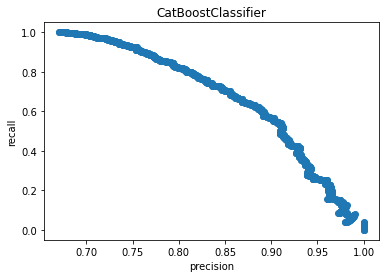

In [388]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('CatBoostClassifier')
plt.show()

In [271]:
params={'iterations':[20, 30, 40],
        'learning_rate':[0.1, 0.3, 0.5],
        'depth':[2, 4, 6]
        }

In [272]:
grid = GridSearchCV(model4,
                    param_grid=params,
                    cv=5,
                    refit=False)

search = grid.fit(x_train[selected_features2 + new_features], y_train['death'])
search.best_params_

{'depth': 4, 'iterations': 30, 'learning_rate': 0.3}

In [389]:
model5 = CatBoostClassifier(depth=4, iterations=30, learning_rate=0.3, random_state=13, silent=True)
model5.fit(x_train[selected_features2 + new_features], y_train['death'])

In [393]:
preds6 = model5.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds6)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.439231, F-Score=0.837, Precision=0.751, Recall=0.943


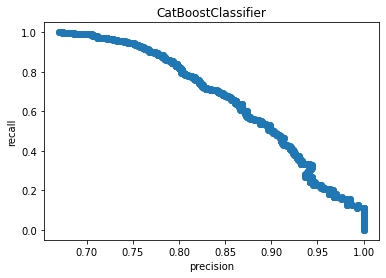

In [394]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('CatBoostClassifier')
plt.show()

Это пока лучший результат. Проверяю модель на тестовой выборке.

In [391]:
preds6_t = model5.predict_proba(x_test[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test['death'], preds6_t)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.434547, F-Score=0.844, Precision=0.764, Recall=0.942


In [274]:
feature_importances_cat = pd.DataFrame(model5.feature_importances_, columns=['coefficient'], index=selected_features2 + new_features)
feature_importances_cat.sort_values(by='coefficient', inplace=True, ascending=False)

In [275]:
feature_importances_cat

,coefficient
ca,18.928140
avtisst,9.683104
age,9.307414
sps,8.170678
ARF/MOSF w/Sepsis,7.252344
scoma,6.168793
adlsc,5.498565
aps,5.497794
num.co,3.794219
bun_nan,3.586903


Пробую удалить признаки, бесполезные и по RandomForest, и по CatBoost: это расса, перевод в категории признаков среднего давления, температуры и pao2/fio2, метки пропусков кроме bun_nan и glucose_nan

In [276]:
selected_features4 = selected_features2 + ['bun_nan', 'glucose_nan'] + list(x_train['dzgroup'].unique())

In [278]:
# model6 = CatBoostClassifier(depth=4, iterations=30, learning_rate=0.3, random_state=13, silent=True)
model5.fit(x_train[selected_features4], y_train['death'])

In [279]:
preds7 = model5.predict_proba(x_valid[selected_features4])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds7)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.432785, F-Score=0.836, Precision=0.747, Recall=0.950


Стало чуть хуже

Я заполняла пропуски в анализах значениями, рекомендованными в описании. Но они соответствую нормальным показателям. Предполагаю, что у пациентов в критическом состоянии это не самые вероятные результаты. Пробую заполнять пропуски модами.

In [290]:
class DataPreprocessing2(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.modes = None
        
        
    def fit(self, x, y=None):
        self.modes = x.mode().loc[0]
        return self
        
       
    def transform(self, x):
        
        # 1. Пропуски
        
        x['edu_nan'] = 0
        x.loc[x['edu'].isna(), 'edu_nan'] = 1
        
#         x['prg2m_nan'] = 0
#         x.loc[x['prg2m'].isna(), 'prg2m_nan'] = 1
        
#         x['prg6m_nan'] = 0
#         x.loc[x['prg6m'].isna(), 'prg6m_nan'] = 1
        
        x['wblc_nan'] = 0
        x.loc[x['wblc'].isna(), 'wblc_nan'] = 1
        
        x['pafi_nan'] = 0
        x.loc[x['pafi'].isna(), 'pafi_nan'] = 1
        
        x['alb_nan'] = 0
        x.loc[x['alb'].isna(), 'alb_nan'] = 1
        
        x['bili_nan'] = 0
        x.loc[x['bili'].isna(), 'bili_nan'] = 1
        
        x['ph_nan'] = 0
        x.loc[x['ph'].isna(), 'ph_nan'] = 1
        
        x['glucose_nan'] = 0
        x.loc[x['glucose'].isna(), 'glucose_nan'] = 1
        
        x['bun_nan'] = 0
        x.loc[x['bun'].isna(), 'bun_nan'] = 1
        
        x['urine_nan'] = 0
        x.loc[x['urine'].isna(), 'urine_nan'] = 1
        
        x['adlp_nan'] = 0
        x.loc[x['adlp'].isna(), 'adlp_nan'] = 1
        
        x['adls_nan'] = 0
        x.loc[x['adls'].isna(), 'adls_nan'] = 1
        
        # Baseline Variable Normal Fill-in Value       моды

        # Serum albumin (alb) 3.5             2.5
        # PaO2/FiO2 ratio (pafi) 333.3        200.0
        # Bilirubin (bili) 1.01               0.399963
        # Creatinine (crea) 1.01              0.899902
        # bun 6.51                             11
        # White blood count (wblc) 9 (thousands) 6.799805
        # Urine output (urine) 2502             0
        
#         x['alb'] = x['alb'].fillna(3.5)
#         x['pafi'] =x['pafi'].fillna(333.3)
#         x['bili'] = x['bili'].fillna(1.01)
#         x['crea'] = x['crea'].fillna(1.01)
#         x['bun'] = x['bun'].fillna(6.51)
#         x['wblc'] = x['wblc'].fillna(9)
#         x['urine'] = x['urine'].fillna(2502)
        x[selected_features] = x[selected_features].fillna(self.modes)

               
        # 2. Выбросы (outliers)
#         В первом приближении не обрабатываю. Достаточно сложно сказать каких значений анализов точно не может быть у пациента
#         в критическом состоянии   


        # 3. категориальные признаки
#         x['sex'] = x['sex'].map({'male': 1, 'female': 2})
#         x['sex'] = x['sex'].astype('int8')
        
#         x['income'] = x['income'].map({'under $11k':1, '$11-$25k':2, '$25-$50k': 3, '>$50k':4})
#         x['income'] = x['income'].astype('str').astype('int8')
        
#         x['ca'] = x['ca'].map({'no': 0, 'yes': 1, 'metastatic': 2}).astype('int8')
        
#         x['dnr'] = x['dnr'].apply(lambda x: 1 if x=='dnr after sadm' or x=='dnr before sadm' else 0)
#         x['dnr'] = x['dnr'].astype('int8')
        
        x['meanbp_cat'] = x['meanbp'].apply(lambda a: 0 if a < 95 else 1)
        x['fever'] = x['temp'].apply(lambda a: 0 if a < 37.5 else 1)
        x['pafi_cat'] = x['pafi'].apply(lambda a: pafi_to_cat(a))
    
        x = pd.concat([x, pd.get_dummies(x['race'])], axis=1)
        x = pd.concat([x, pd.get_dummies(x['dzgroup'])], axis=1)
        
#         4. масштабирование

        tmp = x[selected_features].select_dtypes(exclude=['category', 'object']).nunique()>3
        feature_to_scale = [el for el in tmp.index if tmp[el]]
        x[feature_to_scale] = standard_scale(x[feature_to_scale])
         
        return x


In [291]:
x_tr, x_test, y_tr, y_test = train_test_split(data, y, test_size=0.3, shuffle=True, random_state=13)

x_train, x_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.3, random_state=7)

In [292]:
dp2 = DataPreprocessing2()

In [293]:
x_train = dp2.fit_transform(x_train)
x_valid = dp2.fit_transform(x_valid)
x_test = dp2.fit_transform(x_test)

In [296]:
model4.fit(x_train[selected_features2 + new_features], y_train['death'])

In [297]:
preds8 = model4.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds8)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.370341, F-Score=0.835, Precision=0.736, Recall=0.965


In [298]:
model1.fit(x_train[selected_features2 + new_features], y_train['death'])

RandomForestClassifier(random_state=7)

In [299]:
preds9 = model1.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds9)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.430000, F-Score=0.826, Precision=0.726, Recall=0.958


In [ ]:
# Best Threshold=0.500000, F-Score=0.828, Precision=0.759, Recall=0.911

От такого изменения бустинг работает чуть лучше, случайный лес - чуть хуже. В целом изменения не существенные.

Пробую добавить линейную модель и собрать все, что есть в ансамбль

In [319]:
x_tr, x_test, y_tr, y_test = train_test_split(data, y, test_size=0.3, shuffle=True, random_state=13)

x_train, x_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.3, random_state=7)

In [320]:
x_test = dp.fit_transform(x_test)
x_train = dp.fit_transform(x_train)
x_valid = dp.fit_transform(x_valid)

In [311]:
lr = LogisticRegression()

In [314]:
lr.fit(x_train[selected_features2 + new_features], y_train['death'])

LogisticRegression()

In [315]:
preds10 = lr.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds10)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.333826, F-Score=0.830, Precision=0.725, Recall=0.970


In [316]:
Ada = AdaBoostClassifier()

In [317]:
Ada.fit(x_train[selected_features2 + new_features], y_train['death'])

AdaBoostClassifier()

In [318]:
preds11 = Ada.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds11)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.496096, F-Score=0.827, Precision=0.725, Recall=0.962


In [326]:
vc = VotingClassifier([('rf', model2), ('cat', model5), ('lr', lr), ('ada', Ada) ], voting='soft', n_jobs=-1)

In [327]:
vc.fit(x_train[selected_features2 + new_features], y_train['death'])

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     max_features=15,
                                                     min_samples_leaf=2,
                                                     random_state=7)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x000001F0427299D0>),
                             ('lr', LogisticRegression()),
                             ('ada', AdaBoostClassifier())],
                 n_jobs=-1, voting='soft')

In [395]:
preds12 = vc.predict_proba(x_valid[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_valid['death'], preds12)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.481262, F-Score=0.836, Precision=0.762, Recall=0.925


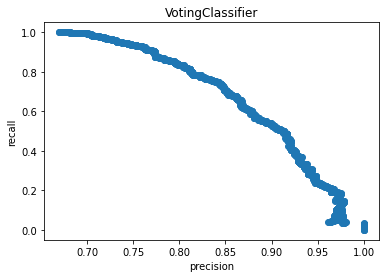

In [396]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('VotingClassifier')
plt.show()

In [331]:
preds12_t = vc.predict_proba(x_test[selected_features2 + new_features])[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test['death'], preds12_t)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.461676, F-Score=0.844, Precision=0.772, Recall=0.931


Результат примерно тот же, что у CatBoost в отдельности

### Сравнение с предсказаниями других моделей

surv2m, surv6m -  оценка выживания через 2 и 6 месяцев по модели SUPPORT

prg2m, prg6m оценка выживания через 2 месяца и 6 месяцев, сделанная врачом

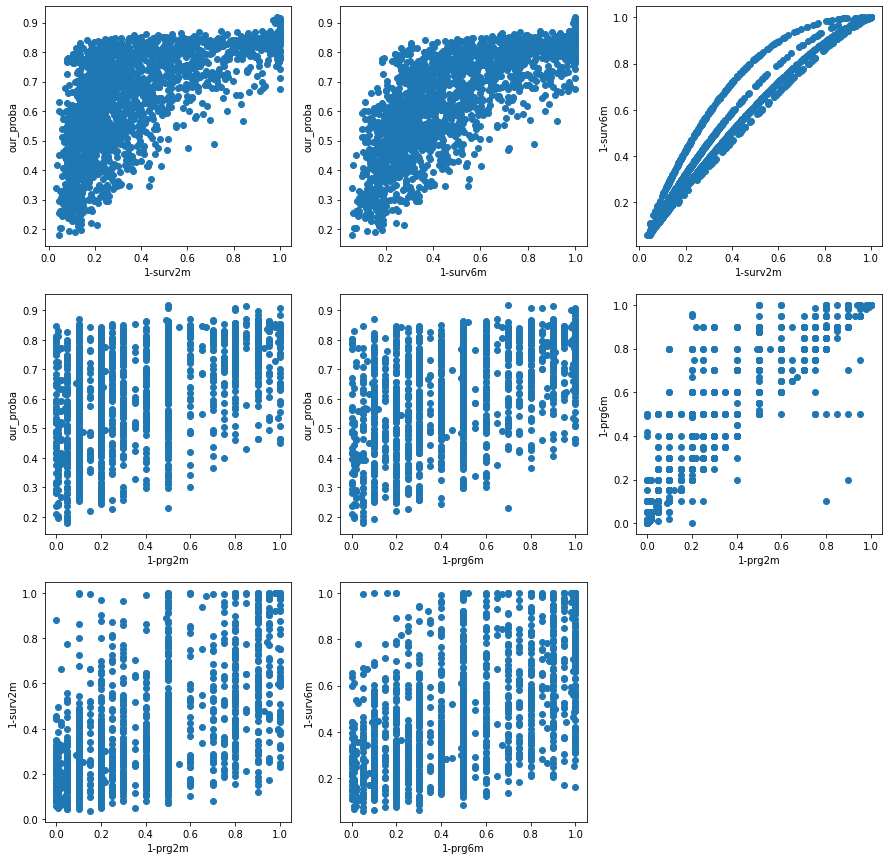

In [397]:
plt.figure(figsize = (15, 15))

plt.subplot(331)
plt.scatter(1-x_valid['surv2m'], preds12)
plt.xlabel('1-surv2m')
plt.ylabel('our_proba')

plt.subplot(332)
plt.scatter(1- x_valid['surv6m'], preds12)
plt.xlabel('1-surv6m')
plt.ylabel('our_proba')

plt.subplot(333)
plt.scatter(1 - x_valid['surv2m'], 1 - x_valid['surv6m'])
plt.xlabel('1-surv2m')
plt.ylabel('1-surv6m')

plt.subplot(334)
plt.scatter(1 - x_valid['prg2m'], preds12)
plt.xlabel('1-prg2m')
plt.ylabel('our_proba')

plt.subplot(335)
plt.scatter(1 - x_valid['prg6m'], preds12)
plt.xlabel('1-prg6m')
plt.ylabel('our_proba')

plt.subplot(336)
plt.scatter(1 - x_valid['prg2m'], 1 - x_valid['prg6m'])
plt.xlabel('1-prg2m')
plt.ylabel('1-prg6m')

plt.subplot(337)
plt.scatter(1 - x_valid['prg2m'], 1 - x_valid['surv2m'])
plt.xlabel('1-prg2m')
plt.ylabel('1-surv2m')


plt.subplot(338)
plt.scatter(1 - x_valid['prg6m'], 1 - x_valid['surv6m'])
plt.xlabel('1-prg6m')
plt.ylabel('1-surv6m')


plt.show()

In [398]:
precision, recall, thresholds = precision_recall_curve(y_valid['death'], 1 - x_valid['surv2m'])

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)

print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.104004, F-Score=0.806, Precision=0.692, Recall=0.965


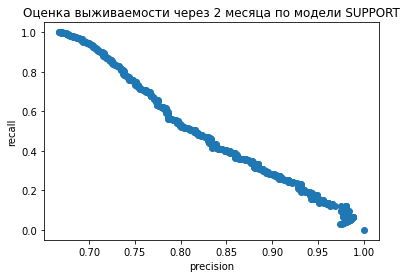

In [400]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Оценка выживаемости через 2 месяца по модели SUPPORT')
plt.show()

In [401]:
precision, recall, thresholds = precision_recall_curve(y_valid['death'], 1-x_valid['surv6m'])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix]))

Best Threshold=0.183105, F-Score=0.813, Precision=0.704, Recall=0.961


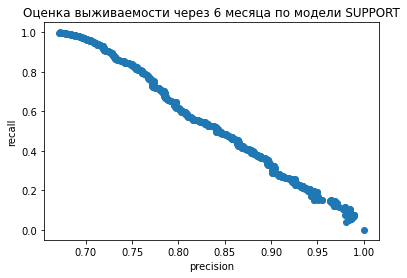

In [402]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('Оценка выживаемости через 6 месяца по модели SUPPORT')
plt.show()

In [403]:
precision, recall, thresholds = precision_recall_curve(y_valid.loc[x_valid['prg2m'].notna(),'death'], 1-x_valid.loc[x_valid['prg2m'].notna(),'prg2m'])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix]))

Best Threshold=0.090000, F-Score=0.804, Precision=0.709, Recall=0.930


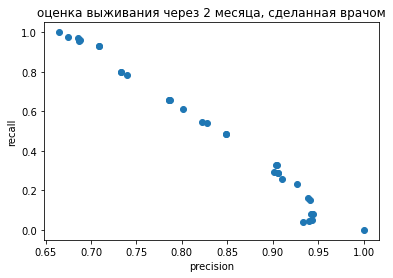

In [404]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('оценка выживания через 2 месяца, сделанная врачом')
plt.show()

In [405]:

precision, recall, thresholds = precision_recall_curve(y_valid.loc[x_valid['prg6m'].notna(),'death'], 1-x_valid.loc[x_valid['prg6m'].notna(),'prg6m'])
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], fscore[ix], precision[ix], recall[ix]))

Best Threshold=0.220000, F-Score=0.808, Precision=0.762, Recall=0.860


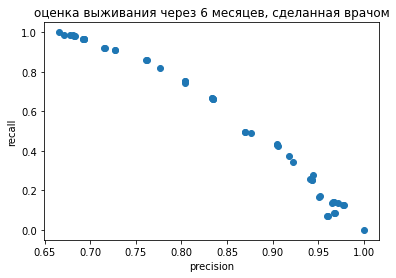

In [406]:
plt.scatter(precision, recall)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('оценка выживания через 6 месяцев, сделанная врачом')
plt.show()

Подписание договора о не проведении реанимационных мероприятий - также в какой-то степени предсказание исхода. Насколько я понимаю, со стороны пациента по согласию врача. Можно посчитать метрики и этого предсказания

In [286]:
precision_dnr = (x_valid['dnr'] & y_valid['death']).sum()/x_valid['dnr'].sum()
precision_dnr

0.9165467625899281

In [288]:
recall_dnr = (x_valid['dnr'] & y_valid['death']).sum() / y_valid['death'].sum()
recall_dnr

0.5007861635220126

In [289]:
fscore_dnr = (2 * precision_dnr * recall_dnr) / (precision_dnr + recall_dnr)
fscore_dnr

0.6476868327402135

Точность выше, чем у всех рассмотренных ранее моделей